# **FYP Sales Forecasting Model Building**

**Import Module**

All the import module will be written below

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib


### Model Training

Read Sales Forecasting Data

In [2]:
grouped_sales_forecast_data = pd.read_csv("Sales Forecasting Data.csv")
grouped_sales_forecast_data

,product_id,order_date,quantity,is_holiday,day,day_of_week,week,month,quarter,year,is_weekend,qty_lag_1,qty_lag_2,qty_lag_3,qty_lag_7,qty_rolling_mean_3,qty_rolling_mean_7,qty_pct_change,cumulative_qty
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20,1,0,20,6,20,5,2,2018,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00088930e925c41fd95ebfe695fd2655,2017-12-12,1,0,12,1,50,12,4,2017,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0009406fd7479715e4bef61dd91f2462,2017-12-21,1,0,21,3,51,12,4,2017,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,000b8f95fcb9e0096488278317764d19,2018-08-01,1,0,1,2,31,8,3,2018,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,000b8f95fcb9e0096488278317764d19,2018-08-10,1,0,10,4,32,8,3,2018,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92830,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-04-19,1,0,19,3,16,4,2,2018,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2
92831,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-05-01,1,1,1,1,18,5,2,2018,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3
92832,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-07,1,0,7,1,32,8,3,2018,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,4
92833,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10,1,0,10,4,32,8,3,2018,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,5


Data Splitting

In [3]:
le = LabelEncoder()
grouped_sales_forecast_data['product_id_encoded'] = le.fit_transform(grouped_sales_forecast_data['product_id'])

features = ['product_id_encoded', 'day', 'day_of_week', 'week', 'month','is_holiday', 'is_weekend', 'year', 'quarter', 
    'qty_lag_1', 'qty_lag_2', 'qty_lag_3', 'qty_lag_7',
    'qty_rolling_mean_3', 'qty_rolling_mean_7',
    'qty_pct_change', 'cumulative_qty']

X = grouped_sales_forecast_data[features]
y = grouped_sales_forecast_data['quantity']

# ensure Date column is datetime
grouped_sales_forecast_data['order_date'] = pd.to_datetime(grouped_sales_forecast_data['order_date'])

# sort just in case
grouped_sales_forecast_data = grouped_sales_forecast_data.sort_values('order_date')

# find split point (70%)
split_date = grouped_sales_forecast_data['order_date'].quantile(0.7)

# split
train = grouped_sales_forecast_data[grouped_sales_forecast_data['order_date'] <= split_date]
test = grouped_sales_forecast_data[grouped_sales_forecast_data['order_date'] > split_date]

print("Train range:", train['order_date'].min(), "→", train['order_date'].max())
print("Test range:", test['order_date'].min(), "→", test['order_date'].max())


Train range: 2016-09-04 00:00:00 → 2018-04-16 00:00:00
Test range: 2018-04-17 00:00:00 → 2018-09-03 00:00:00


In [4]:
X_train = train[features]
y_train = train['quantity']
X_test = test[features]
y_test = test['quantity']

Overfitting Checking Function

In [5]:
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, overfit_threshold=0.05):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute metrics
    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

    train_metrics = metrics(y_train, y_train_pred)
    test_metrics = metrics(y_test, y_test_pred)

    # Check overfitting
    overfitting = train_metrics["R2"] - test_metrics["R2"] > overfit_threshold

    print("=== Training Metrics ===")
    for k, v in train_metrics.items():
        print(f"{k}: {v:.4f}" if k != "MAPE" else f"{k}: {v:.2f}%")

    print("\n=== Test Metrics ===")
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}" if k != "MAPE" else f"{k}: {v:.2f}%")

    if overfitting:
        print("\n⚠️ Warning: Model may be overfitting (train R² >> test R²)")
    else:
        print("\n✅ Model generalizes well (no major overfitting detected)")

**Linear Regression**

In [6]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

Linear Regression Evaluation Metrics:
+---------------------------------------+-----------+
| Metric                                |     Score |
+=======================================+===========+
| Mean Absolute Error (MAE)             |  0.164975 |
+---------------------------------------+-----------+
| Root Mean Squared Error (RMSE)        |  0.44722  |
+---------------------------------------+-----------+
| Mean Absolute Percentage Error (MAPE) | 10.9425   |
+---------------------------------------+-----------+
| R² Score                              |  0.535868 |
+---------------------------------------+-----------+


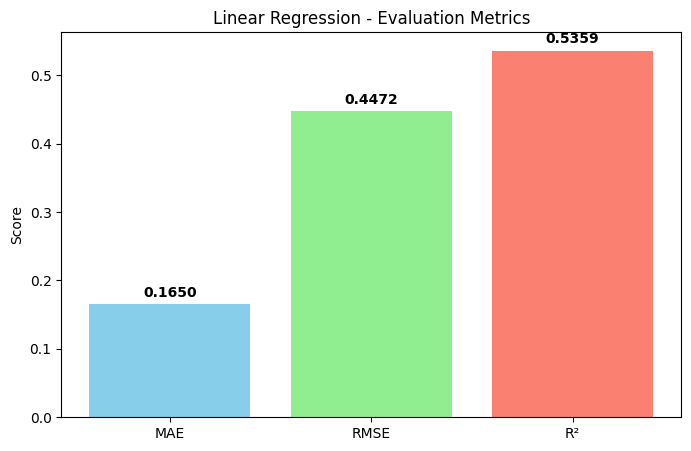

In [7]:
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
lr_r2 = r2_score(y_test, y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", lr_mae],
    ["Root Mean Squared Error (RMSE)", lr_rmse],
    ["Mean Absolute Percentage Error (MAPE)", lr_mape],
    ["R² Score", lr_r2]
]

print("Linear Regression Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [lr_mae, lr_rmse, lr_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("Linear Regression - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Check Overfitting

In [8]:
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

=== Training Metrics ===
MAE: 0.1672
RMSE: 0.4384
MAPE: 11.17%
R2: 0.5771

=== Test Metrics ===
MAE: 0.1650
RMSE: 0.4472
MAPE: 10.94%
R2: 0.5359

✅ Model generalizes well (no major overfitting detected)


**Random Forest**

In [9]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

Random Forest Evaluation Metrics:
+---------------------------------------+-----------+
| Metric                                |     Score |
+=======================================+===========+
| Mean Absolute Error (MAE)             | 0.0027536 |
+---------------------------------------+-----------+
| Root Mean Squared Error (RMSE)        | 0.0815069 |
+---------------------------------------+-----------+
| Mean Absolute Percentage Error (MAPE) | 0.039184  |
+---------------------------------------+-----------+
| R² Score                              | 0.984583  |
+---------------------------------------+-----------+


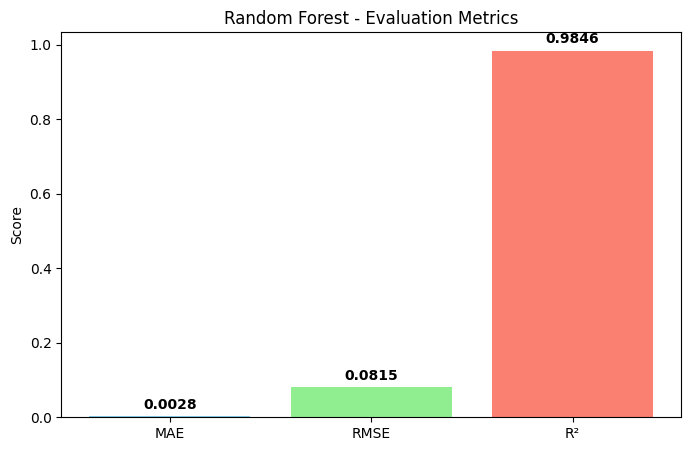

In [10]:
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rf_r2 = r2_score(y_test, y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", rf_mae],
    ["Root Mean Squared Error (RMSE)", rf_rmse],
    ["Mean Absolute Percentage Error (MAPE)", rf_mape],
    ["R² Score", rf_r2]
]

print("Random Forest Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [rf_mae, rf_rmse, rf_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("Random Forest - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Check Overfitting

In [11]:
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

=== Training Metrics ===
MAE: 0.0010
RMSE: 0.0378
MAPE: 0.01%
R2: 0.9968

=== Test Metrics ===
MAE: 0.0028
RMSE: 0.0815
MAPE: 0.04%
R2: 0.9846

✅ Model generalizes well (no major overfitting detected)


**XGBoost**

In [12]:
model = XGBRegressor(random_state=42, objective='reg:squarederror')  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

XGBoost Evaluation Metrics:
+---------------------------------------+------------+
| Metric                                |      Score |
+=======================================+============+
| Mean Absolute Error (MAE)             | 0.00223035 |
+---------------------------------------+------------+
| Root Mean Squared Error (RMSE)        | 0.0869721  |
+---------------------------------------+------------+
| Mean Absolute Percentage Error (MAPE) | 0.0265258  |
+---------------------------------------+------------+
| R² Score                              | 0.982447   |
+---------------------------------------+------------+


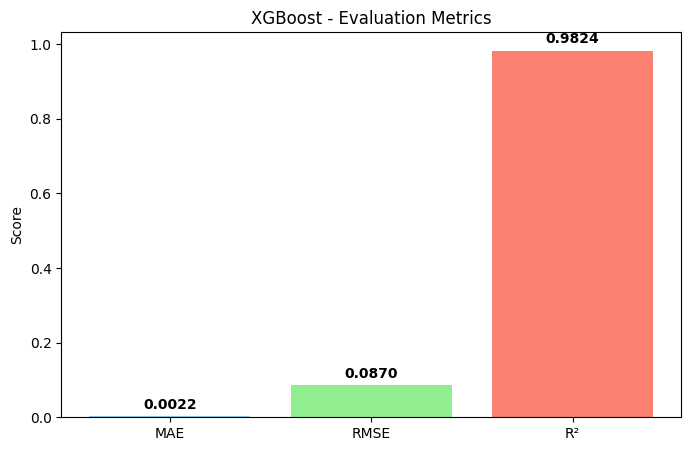

In [13]:
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
xgb_r2 = r2_score(y_test, y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", xgb_mae],
    ["Root Mean Squared Error (RMSE)", xgb_rmse],
    ["Mean Absolute Percentage Error (MAPE)", xgb_mape],
    ["R² Score", xgb_r2]
]

print("XGBoost Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [xgb_mae, xgb_rmse, xgb_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("XGBoost - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Check Overfitting

In [14]:
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

=== Training Metrics ===
MAE: 0.0000
RMSE: 0.0008
MAPE: 0.00%
R2: 1.0000

=== Test Metrics ===
MAE: 0.0022
RMSE: 0.0870
MAPE: 0.03%
R2: 0.9824

✅ Model generalizes well (no major overfitting detected)


**LightGBM**

In [15]:
model = LGBMRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 65173, number of used features: 17
[LightGBM] [Info] Start training from score 1.191245


Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

LightGBM Evaluation Metrics:
+---------------------------------------+------------+
| Metric                                |      Score |
+=======================================+============+
| Mean Absolute Error (MAE)             | 0.00915113 |
+---------------------------------------+------------+
| Root Mean Squared Error (RMSE)        | 0.131681   |
+---------------------------------------+------------+
| Mean Absolute Percentage Error (MAPE) | 0.318004   |
+---------------------------------------+------------+
| R² Score                              | 0.959761   |
+---------------------------------------+------------+


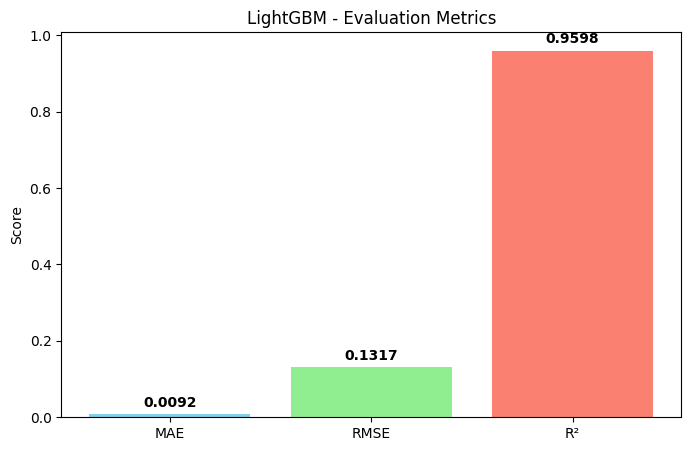

In [16]:
lgbm_mae = mean_absolute_error(y_test, y_pred)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
lgbm_r2 = r2_score(y_test, y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", lgbm_mae],
    ["Root Mean Squared Error (RMSE)", lgbm_rmse],
    ["Mean Absolute Percentage Error (MAPE)", lgbm_mape],
    ["R² Score", lgbm_r2]
]

print("LightGBM Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [lgbm_mae, lgbm_rmse, lgbm_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("LightGBM - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Check Overfitting

In [17]:
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

=== Training Metrics ===
MAE: 0.0069
RMSE: 0.1013
MAPE: 0.25%
R2: 0.9774

=== Test Metrics ===
MAE: 0.0092
RMSE: 0.1317
MAPE: 0.32%
R2: 0.9598

✅ Model generalizes well (no major overfitting detected)


### Hyperparameter Tuning

**Linear Regression**

In [18]:
param_space = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [-1, 1, 5, 10, 15, None],
    'positive': [True, False]
}

lr_random_search = RandomizedSearchCV(
    LinearRegression(),
    param_space,
    n_iter=100,                
    scoring='r2',             
    cv=5,                     
    random_state=42,
    n_jobs=-1                 
)

lr_random_search.fit(X_train, y_train)

print("Best parameters:", lr_random_search.best_params_)
print("Best CV F1-score:", lr_random_search.best_score_)

c:\laragon\www\fyp-model-building\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'positive': False, 'n_jobs': -1, 'fit_intercept': False, 'copy_X': True}
Best CV F1-score: 0.556639491535114


Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

Linear Regression Evaluation Metrics:
+---------------------------------------+-----------+
| Metric                                |     Score |
+=======================================+===========+
| Mean Absolute Error (MAE)             |  0.176403 |
+---------------------------------------+-----------+
| Root Mean Squared Error (RMSE)        |  0.447032 |
+---------------------------------------+-----------+
| Mean Absolute Percentage Error (MAPE) | 12.0823   |
+---------------------------------------+-----------+
| R² Score                              |  0.536259 |
+---------------------------------------+-----------+


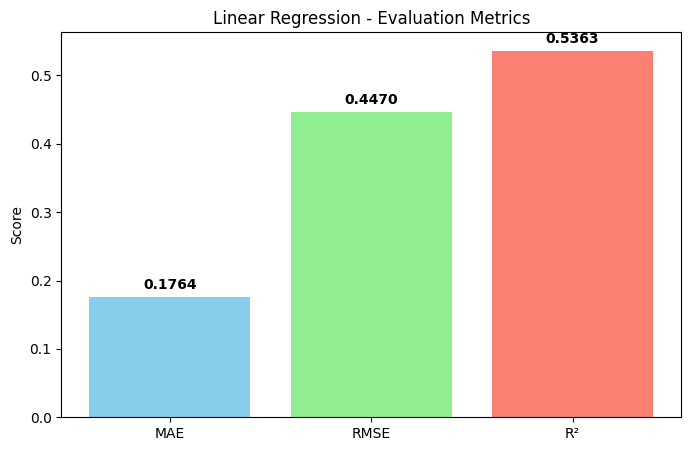

In [19]:
best_lr_model = lr_random_search.best_estimator_
best_lr_y_pred = best_lr_model.predict(X_test)

best_lr_mae = mean_absolute_error(y_test, best_lr_y_pred)
best_lr_rmse = np.sqrt(mean_squared_error(y_test, best_lr_y_pred))
best_lr_mape = np.mean(np.abs((y_test - best_lr_y_pred) / y_test)) * 100
best_lr_r2 = r2_score(y_test, best_lr_y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", best_lr_mae],
    ["Root Mean Squared Error (RMSE)", best_lr_rmse],
    ["Mean Absolute Percentage Error (MAPE)", best_lr_mape],
    ["R² Score", best_lr_r2]
]

print("Linear Regression Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [best_lr_mae, best_lr_rmse, best_lr_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("Linear Regression - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Performance Comparison

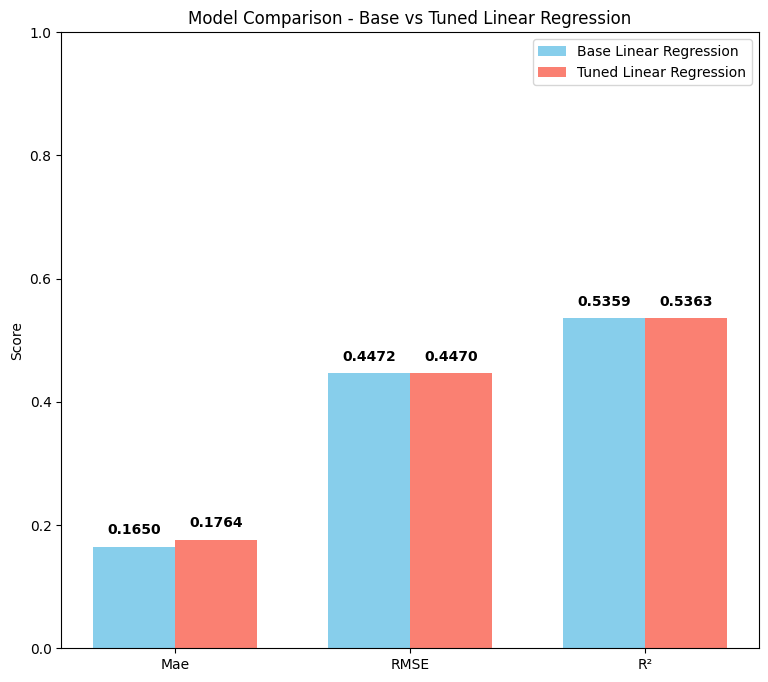

In [20]:
metrics = ["Mae", "RMSE", "R²"]
model1_scores = [lr_mae, lr_rmse, lr_r2]
model2_scores = [best_lr_mae, best_lr_rmse, best_lr_r2] 

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,8))
plt.bar(x - width/2, model1_scores, width, label='Base Linear Regression', color='skyblue')
plt.bar(x + width/2, model2_scores, width, label='Tuned Linear Regression', color='salmon')
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Comparison - Base vs Tuned Linear Regression")
plt.legend()

for i, v in enumerate(model1_scores):
    plt.text(i - width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
for i, v in enumerate(model2_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


**Random Forest**

In [21]:
param_space = {
    'bootstrap': [True, False],                         
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
    'max_features': ['sqrt', None],                     
    'min_samples_leaf': [1, 2, 4],                      
    'min_samples_split': [2, 5, 10],                    
    'n_estimators': [100, 200, 400, 600, 800, 1000]
}

rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_space,
    n_iter=100,              
    scoring='r2',             
    cv=5,                     
    verbose=2,                
    random_state=42,
    n_jobs=-1                 
)

rf_random_search.fit(X_train, y_train)
print("Best parameters:", rf_random_search.best_params_)
print("Best CV R² score:", rf_random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Best CV R² score: 0.9735657150474246


Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

Random Forest Evaluation Metrics:
+---------------------------------------+------------+
| Metric                                |      Score |
+=======================================+============+
| Mean Absolute Error (MAE)             | 0.00282725 |
+---------------------------------------+------------+
| Root Mean Squared Error (RMSE)        | 0.0838654  |
+---------------------------------------+------------+
| Mean Absolute Percentage Error (MAPE) | 0.0408584  |
+---------------------------------------+------------+
| R² Score                              | 0.983678   |
+---------------------------------------+------------+


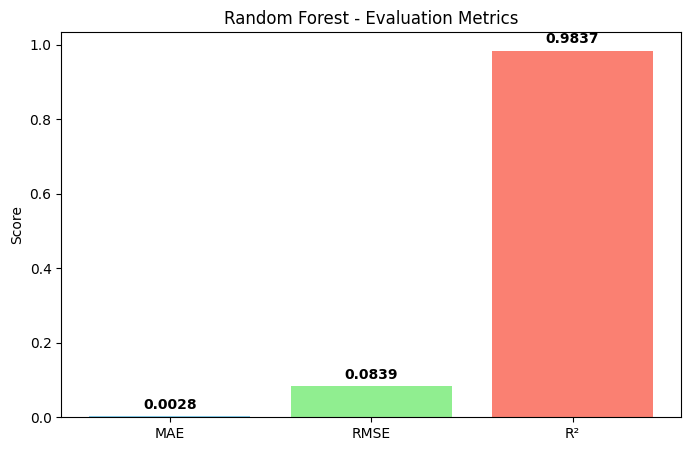

In [22]:
best_rf_model = rf_random_search.best_estimator_
best_rf_y_pred = best_rf_model.predict(X_test)

best_rf_mae = mean_absolute_error(y_test, best_rf_y_pred)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_y_pred))
best_rf_mape = np.mean(np.abs((y_test - best_rf_y_pred) / y_test)) * 100
best_rf_r2 = r2_score(y_test, best_rf_y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", best_rf_mae],
    ["Root Mean Squared Error (RMSE)", best_rf_rmse],
    ["Mean Absolute Percentage Error (MAPE)", best_rf_mape],
    ["R² Score", best_rf_r2]
]

print("Random Forest Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [best_rf_mae, best_rf_rmse, best_rf_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("Random Forest - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Performance Comparison

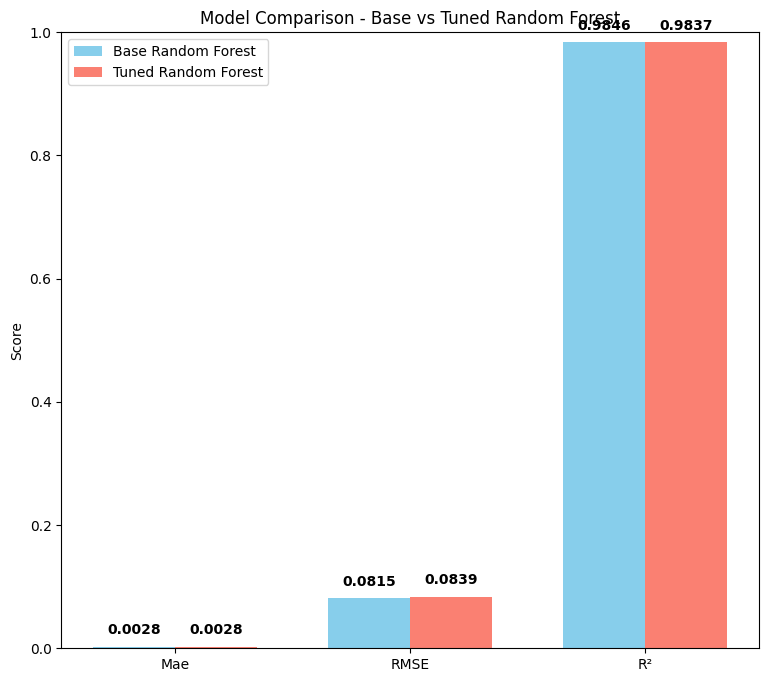

In [23]:
metrics = ["Mae", "RMSE", "R²"]
model1_scores = [rf_mae, rf_rmse, rf_r2]
model2_scores = [best_rf_mae, best_rf_rmse, best_rf_r2] 

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,8))
plt.bar(x - width/2, model1_scores, width, label='Base Random Forest', color='skyblue')
plt.bar(x + width/2, model2_scores, width, label='Tuned Random Forest', color='salmon')
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Comparison - Base vs Tuned Random Forest")
plt.legend()

for i, v in enumerate(model1_scores):
    plt.text(i - width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
for i, v in enumerate(model2_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


**XGBoost**

In [24]:
param_space = {
    'n_estimators': [100, 200, 300, 400, 500],         
    'max_depth': [3, 5, 6, 7, 9, 10],                
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],   
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],           
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],    
    'gamma': [0, 0.1, 0.2, 0.3],                     
    'reg_alpha': [0, 0.01, 0.1],                     
    'reg_lambda': [1, 1.5, 2]                         
}

xgb_random_search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_space,
    n_iter=100,            
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

print("Best parameters:", xgb_random_search.best_params_)
print("Best CV R² score:", xgb_random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV R² score: 0.9863739967346191


Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

XGBoost Evaluation Metrics:
+---------------------------------------+------------+
| Metric                                |      Score |
+=======================================+============+
| Mean Absolute Error (MAE)             | 0.00214155 |
+---------------------------------------+------------+
| Root Mean Squared Error (RMSE)        | 0.0607684  |
+---------------------------------------+------------+
| Mean Absolute Percentage Error (MAPE) | 0.059196   |
+---------------------------------------+------------+
| R² Score                              | 0.991431   |
+---------------------------------------+------------+


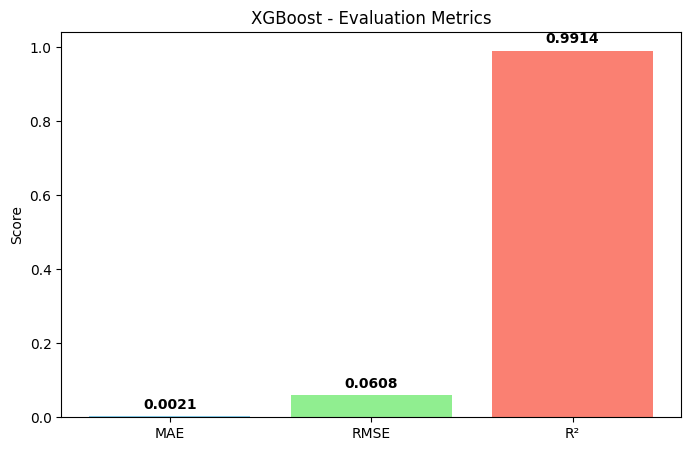

In [25]:
best_xgb_model = xgb_random_search.best_estimator_
best_xgb_y_pred = best_xgb_model.predict(X_test)

best_xgb_mae = mean_absolute_error(y_test, best_xgb_y_pred)
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, best_xgb_y_pred))
best_xgb_mape = np.mean(np.abs((y_test - best_xgb_y_pred) / y_test)) * 100
best_xgb_r2 = r2_score(y_test, best_xgb_y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", best_xgb_mae],
    ["Root Mean Squared Error (RMSE)", best_xgb_rmse],
    ["Mean Absolute Percentage Error (MAPE)", best_xgb_mape],
    ["R² Score", best_xgb_r2]
]

print("XGBoost Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [best_xgb_mae, best_xgb_rmse, best_xgb_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("XGBoost - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Performance Comparison

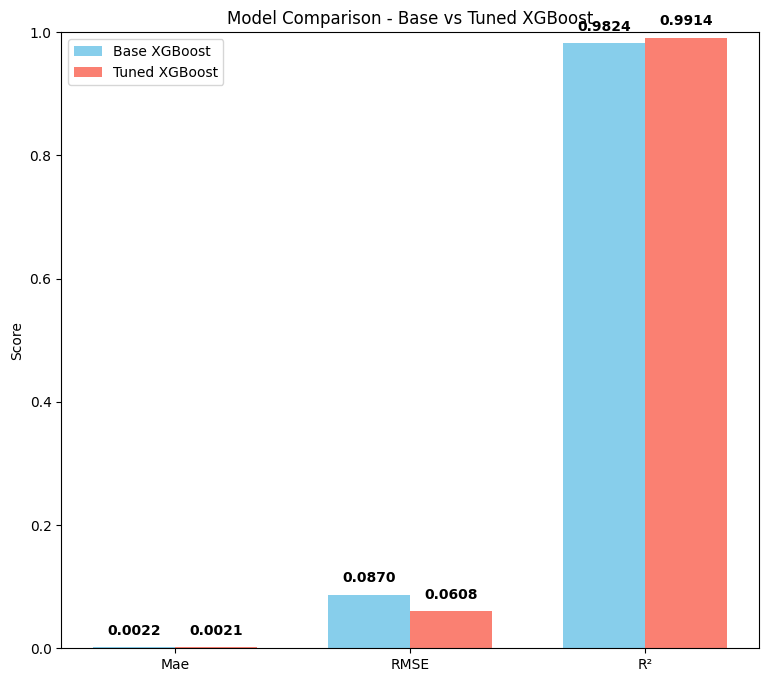

In [28]:
metrics = ["Mae", "RMSE", "R²"]
model1_scores = [xgb_mae, xgb_rmse, xgb_r2]
model2_scores = [best_xgb_mae, best_xgb_rmse, best_xgb_r2] 

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,8))
plt.bar(x - width/2, model1_scores, width, label='Base XGBoost', color='skyblue')
plt.bar(x + width/2, model2_scores, width, label='Tuned XGBoost', color='salmon')
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Comparison - Base vs Tuned XGBoost")
plt.legend()

for i, v in enumerate(model1_scores):
    plt.text(i - width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
for i, v in enumerate(model2_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


**LightGBM**

In [29]:
param_space = {
    'n_estimators': [100, 200, 300, 400, 500],      
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        
    'num_leaves': [15, 31, 50, 70],                 
    'max_depth': [-1, 5, 10, 20],                   
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],         
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  
    'reg_alpha': [0, 0.01, 0.1],                    
    'reg_lambda': [0, 0.1, 0.5, 1.0]               
}
lgbm_random_search = RandomizedSearchCV(
    LGBMRegressor(random_state=42, n_jobs=-1),
    param_space,
    n_iter=100,             
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgbm_random_search.fit(X_train, y_train)

print("Best parameters:", lgbm_random_search.best_params_)
print("Best CV R² score:", lgbm_random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 65173, number of used features: 17
[LightGBM] [Info] Start training from score 1.191245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

Model Evaluation (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2))

LightGBM Evaluation Metrics:
+---------------------------------------+-----------+
| Metric                                |     Score |
+=======================================+===========+
| Mean Absolute Error (MAE)             | 0.0105344 |
+---------------------------------------+-----------+
| Root Mean Squared Error (RMSE)        | 0.107576  |
+---------------------------------------+-----------+
| Mean Absolute Percentage Error (MAPE) | 0.499721  |
+---------------------------------------+-----------+
| R² Score                              | 0.973145  |
+---------------------------------------+-----------+


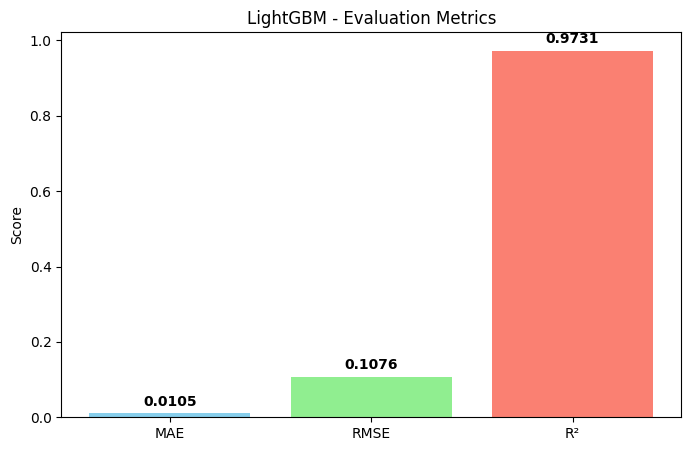

In [30]:
best_lgbm_model = lgbm_random_search.best_estimator_
best_lgbm_y_pred = best_lgbm_model.predict(X_test)

best_lgbm_mae = mean_absolute_error(y_test, best_lgbm_y_pred)
best_lgbm_rmse = np.sqrt(mean_squared_error(y_test, best_lgbm_y_pred))
best_lgbm_mape = np.mean(np.abs((y_test - best_lgbm_y_pred) / y_test)) * 100
best_lgbm_r2 = r2_score(y_test, best_lgbm_y_pred)

# Prepare table for tabulate
eval_table = [
    ["Metric", "Score"],
    ["Mean Absolute Error (MAE)", best_lgbm_mae],
    ["Root Mean Squared Error (RMSE)", best_lgbm_rmse],
    ["Mean Absolute Percentage Error (MAPE)", best_lgbm_mape],
    ["R² Score", best_lgbm_r2]
]

print("LightGBM Evaluation Metrics:")
print(tabulate(eval_table, headers="firstrow", tablefmt="grid"))

# Plot the metrics
metrics = ["MAE", "RMSE", "R²"]
scores = [best_lgbm_mae, best_lgbm_rmse, best_lgbm_r2]

plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=['skyblue','lightgreen','salmon','orange'])
plt.title("LightGBM - Evaluation Metrics")
plt.ylabel("Score")

for i, v in enumerate(scores):
    plt.text(i, v + max(scores)*0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()

Performance Comparison

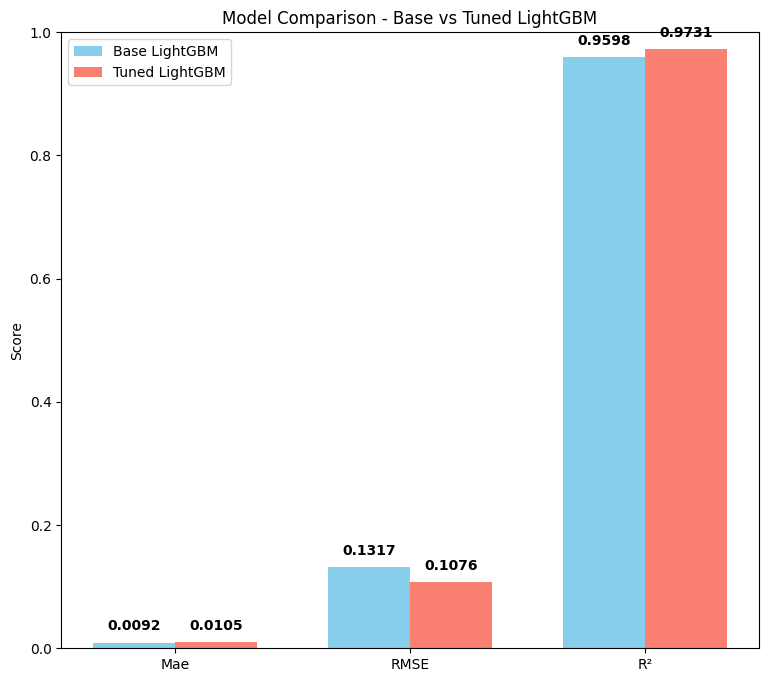

In [31]:
metrics = ["Mae", "RMSE", "R²"]
model1_scores = [lgbm_mae, lgbm_rmse, lgbm_r2]
model2_scores = [best_lgbm_mae, best_lgbm_rmse, best_lgbm_r2] 

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,8))
plt.bar(x - width/2, model1_scores, width, label='Base LightGBM', color='skyblue')
plt.bar(x + width/2, model2_scores, width, label='Tuned LightGBM', color='salmon')
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Comparison - Base vs Tuned LightGBM")
plt.legend()

for i, v in enumerate(model1_scores):
    plt.text(i - width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
for i, v in enumerate(model2_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


**Performance Comparison Chart**

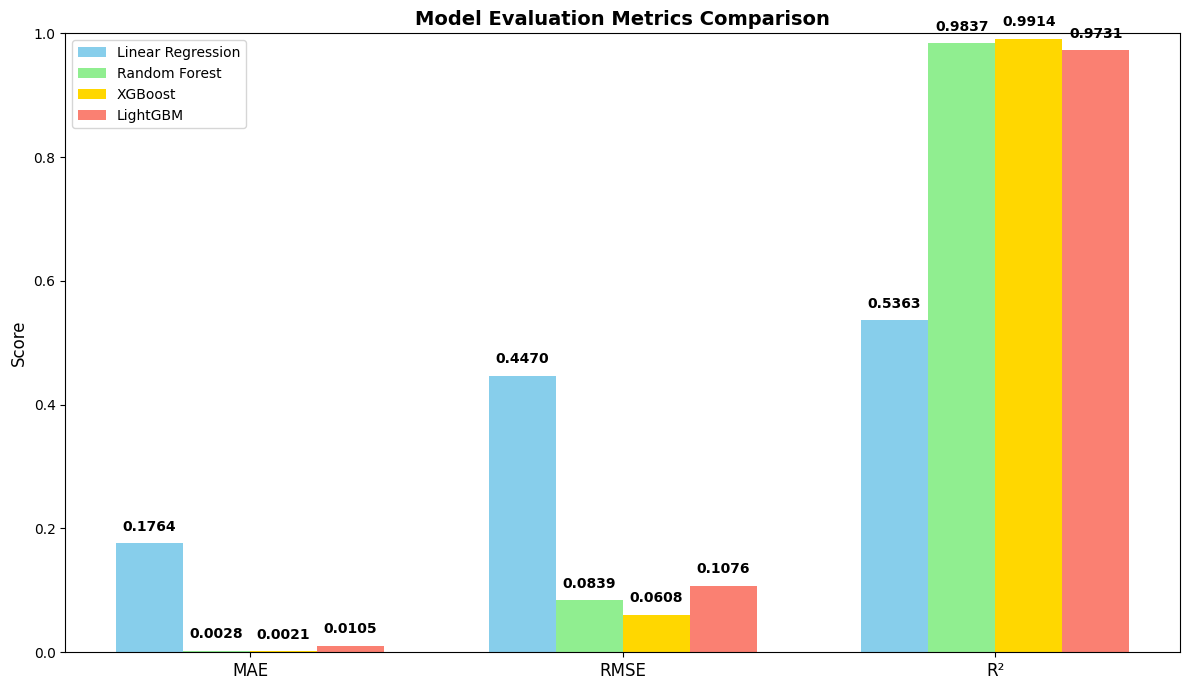

In [32]:
lr_scores = [best_lr_mae, best_lr_rmse, best_lr_r2]
rf_scores = [best_rf_mae, best_rf_rmse, best_rf_r2]
xgb_scores  = [best_xgb_mae, best_xgb_rmse, best_xgb_r2]
lgbm_scores = [best_lgbm_mae, best_lgbm_rmse, best_lgbm_r2]

metrics = ["MAE", "RMSE", "R²"]
x = np.arange(len(metrics))
width = 0.18 

plt.figure(figsize=(12, 7))

# Plot bars
plt.bar(x - 1.5*width, lr_scores,   width, label="Linear Regression", color="skyblue")
plt.bar(x - 0.5*width, rf_scores,   width, label="Random Forest",     color="lightgreen")
plt.bar(x + 0.5*width, xgb_scores,  width, label="XGBoost",           color="gold")
plt.bar(x + 1.5*width, lgbm_scores, width, label="LightGBM",          color="salmon")

# Formatting
plt.ylim(0, 1)
plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Model Evaluation Metrics Comparison", fontsize=14, fontweight="bold")
plt.legend()

# Add score labels
all_scores = [lr_scores, rf_scores, xgb_scores, lgbm_scores]
offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

for offset, scores in zip(offsets, all_scores):
    for j, v in enumerate(scores):
        plt.text(j + offset, v + 0.02, f"{v:.4f}", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Deploy best model**

In [34]:
joblib.dump(best_xgb_model, "sales_forecasting_model.pkl")
print("✅ Model saved as sales_forecasting_model.pkl")

✅ Model saved as sales_forecasting_model.pkl
